In [1]:
import sys 
sys.path.append('../..')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from utils.metrics import compute_blockpush_metrics, compute_kitchen_sequences, tasks_to_complete

# Threshold analysis

Blockpush

In [2]:
demos_load_dir = Path('../../data/bet_data_release/blockpush/multimodal_push_observations.npy')
snapshots_load_dir = Path('../../eval_runs/eval_blockpush/reproduction/paper_params/0/')

In [3]:
# Table 5

thresholds = [0.04, 0.05]

P1_04_demos = 0
P2_04_demos = 0
P1_05_demos = 0
P2_05_demos = 0

for threshold in thresholds:
    prob_metcs, abs_metcs, _ = compute_blockpush_metrics(
                                    data=np.load(demos_load_dir, allow_pickle=True),  
                                    eval_was_vectorized=False,
                                    tolerance=threshold)
    if threshold == 0.04:
        P2_04_demos = prob_metcs['Probabilities/P2 (block enters the target)']
        P1_04_demos = prob_metcs['Probabilities/P1 (block enters the target)']
    elif threshold == 0.05:
        P2_05_demos = prob_metcs['Probabilities/P2 (block enters the target)']
        P1_05_demos = prob_metcs['Probabilities/P1 (block enters the target)']
    else:
        raise ValueError('Threshold not supported')

print('Demonstrations')
print(f'P1 for threshold of 0.04: {P1_04_demos}')
print(f'P2 for threshold of 0.04: {P2_04_demos}')
print(f'P1 for threshold of 0.05: {P1_05_demos}')
print(f'P2 for threshold of 0.05: {P2_05_demos}')

Demonstrations
P1 for threshold of 0.04: 1.0
P2 for threshold of 0.04: 0.995
P1 for threshold of 0.05: 1.0
P2 for threshold of 0.05: 0.996


In [4]:
# Table 5

P1_04_bet = 0
P2_04_bet = 0
P1_05_bet = 0
P2_05_bet = 0


if len(list(snapshots_load_dir.glob("*"))) == 0:
    raise Exception("The provided directory is empty")

for threshold in thresholds:
    for subdir in snapshots_load_dir.glob("*"):
        if "snapshot_" in str(subdir):
            prob_metcs, abs_metcs, _ = compute_blockpush_metrics(data=np.load(subdir / 'obs_trajs.npy', allow_pickle=True),  
                                      done_at_array=np.load(subdir / 'done_at.npy', allow_pickle=True),
                                      eval_was_vectorized=True,
                                      tolerance=threshold)
            if threshold == 0.04:
                P1_04_bet += prob_metcs['Probabilities/P1 (block enters the target)']
                P2_04_bet += prob_metcs['Probabilities/P2 (block enters the target)']
            elif threshold == 0.05:
                P1_05_bet += prob_metcs['Probabilities/P1 (block enters the target)']
                P2_05_bet += prob_metcs['Probabilities/P2 (block enters the target)']
            else:
                ValueError('Threshold not supported')

n_models = len([x for x in snapshots_load_dir.glob("*") if "snapshot_" in str(x)])

print('BeT')
print(f'P1 for threshold of 0.04: {P1_04_bet/n_models}')
print(f'P2 for threshold of 0.04: {P2_04_bet/n_models}') # Incorrectly rounded as 0.11 in the paper.
print(f'P1 for threshold of 0.05: {P1_05_bet/n_models}')
print(f'P2 for threshold of 0.05: {P2_05_bet/n_models}') 

BeT
P1 for threshold of 0.04: 0.8564
P2 for threshold of 0.04: 0.1026
P1 for threshold of 0.05: 0.9393999999999998
P2 for threshold of 0.05: 0.18159999999999998


Kitchen

In [5]:
demonstration_dataset = np.load('../../data/bet_data_release/kitchen/observations_seq.npy', allow_pickle=True)
demonstration_dataset = np.swapaxes(demonstration_dataset, 0, 1)

In [6]:
thresholds = [0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
sequence_elements_threshold_dep = []
sequence_elements_threshold_dep_og = []

for threshold in thresholds:
    elements, mappings, _ = compute_kitchen_sequences(demonstration_dataset, threshold=threshold)
    sequence_elements_threshold_dep_og.append(elements)

In [7]:
results = [[] for _ in range(len(tasks_to_complete))]

def compute_threshold_precision(task, results, sequence_elements_threshold_dep, tasks_to_complete):
    
    for sequence_tresh in sequence_elements_threshold_dep:
        task_thresh_counter = 0
        for seq in sequence_tresh:
            if task in seq:
                task_thresh_counter += 1
        results[tasks_to_complete.index(task)].append(task_thresh_counter / len(sequence_tresh))

    return results


for task in tasks_to_complete:
    results_og = compute_threshold_precision(task, results, sequence_elements_threshold_dep_og, tasks_to_complete)        

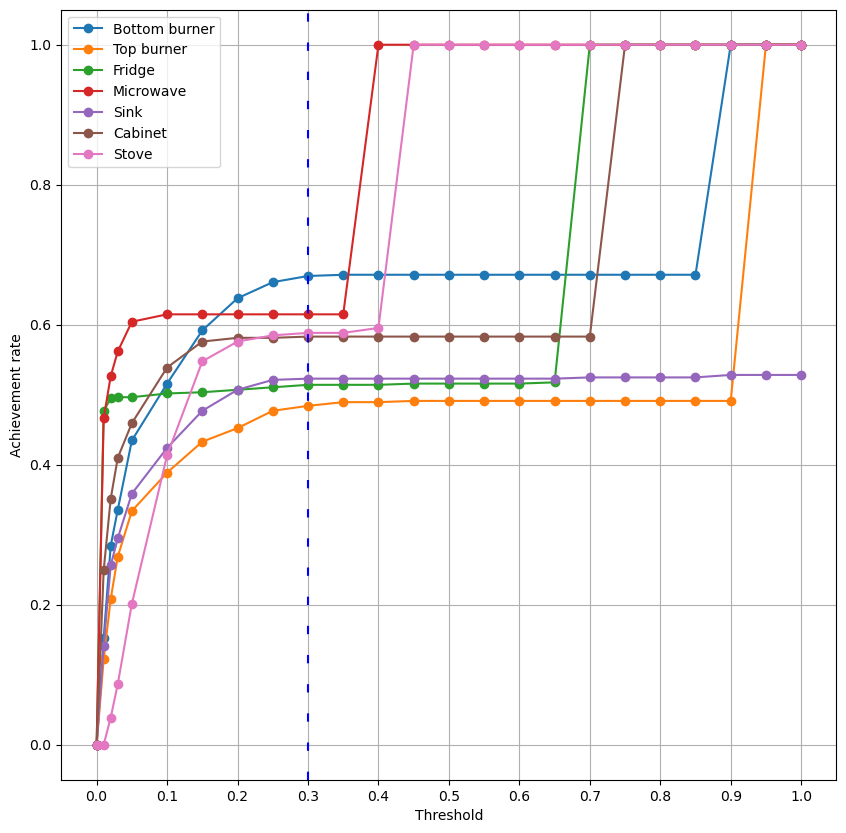

In [8]:
plt.figure(figsize=(10, 10))
plt.grid()
plt.plot(thresholds, results_og[0], label='Bottom burner', marker='o')
plt.plot(thresholds, results_og[1], label='Top burner', marker='o')
plt.plot(thresholds, results_og[2], label='Fridge', marker='o')
plt.plot(thresholds, results_og[3], label='Microwave', marker='o')
plt.plot(thresholds, results_og[4], label='Sink', marker='o')
plt.plot(thresholds, results_og[5], label='Cabinet', marker='o')
plt.plot(thresholds, results_og[6], label='Stove', marker='o')
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.axvline(x=0.3, color='b', linestyle=(0, (4, 10)))
plt.xlabel('Threshold')
plt.ylabel('Achievement rate')
plt.legend()
plt.show()

# Proposed metrics for Blockpush

In [9]:
prob_metcs, abs_metcs, _ = compute_blockpush_metrics(
                                    data=np.load(demos_load_dir, allow_pickle=True),  
                                    eval_was_vectorized=False,
                                    tolerance=0.05)

In [10]:
# Table 4
print('Demonstrations')
print('Distance between block positions at t and t+1')
print('R1: ', prob_metcs['Probabilities/R1 (block-block distance)'])
print('R2: ', prob_metcs['Probabilities/R2 (block-block distance)'])
print('Distance between arm and block')
print('R1,', prob_metcs['Probabilities/R1 (block-arm distance)'])
print('R2', prob_metcs['Probabilities/R2 (block-arm distance)'])
print('Block enters the target')
print('P1', prob_metcs['Probabilities/P1 (block enters the target)'])
print('P2', prob_metcs['Probabilities/P2 (block enters the target)'])
print('Block stays in the target')
print('P1', prob_metcs['Probabilities/P1 (block stays in target)'])
print('P2', prob_metcs['Probabilities/P2 (block stays in target)'])

Demonstrations
Distance between block positions at t and t+1
R1:  1.0
R2:  1.0
Distance between arm and block
R1, 1.0
R2 1.0
Block enters the target
P1 1.0
P2 0.996
Block stays in the target
P1 0.997
P2 0.983


In [11]:
prob_metcs, abs_metcs, _ = compute_blockpush_metrics(
                                    data=np.load(str(snapshots_load_dir) + '/snapshot_0/obs_trajs.npy', allow_pickle=True),  
                                    eval_was_vectorized=True,
                                    done_at_array=np.load(subdir / 'done_at.npy', allow_pickle=True),
                                    tolerance=0.05)

In [12]:
# Table 4
print('Demonstrations')
print('Distance between block positions at t and t+1')
print('R1: ', prob_metcs['Probabilities/R1 (block-block distance)'])
print('R2: ', prob_metcs['Probabilities/R2 (block-block distance)'])
print('Distance between arm and block')
print('R1,', prob_metcs['Probabilities/R1 (block-arm distance)'])
print('R2', prob_metcs['Probabilities/R2 (block-arm distance)'])
print('Block enters the target')
print('P1', prob_metcs['Probabilities/P1 (block enters the target)'])
print('P2', prob_metcs['Probabilities/P2 (block enters the target)'])
print('Block stays in the target')
print('P1', prob_metcs['Probabilities/P1 (block stays in target)'])
print('P2', prob_metcs['Probabilities/P2 (block stays in target)'])

Demonstrations
Distance between block positions at t and t+1
R1:  1.0
R2:  0.975
Distance between arm and block
R1, 1.0
R2 0.976
Block enters the target
P1 0.94
P2 0.18
Block stays in the target
P1 0.682
P2 0.002
